# Learning strategies

In [1]:
from pyspark import SparkContext
import json
import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy.stats as stats

sc = SparkContext("local[*]", "ADA")
sc.defaultParallelism

8

In [2]:
rdd = sc.textFile('data/spark/features/').map(json.loads)
print('number of learning strategies', rdd.count())

number of learning strategies 41791


In [3]:
df = pd.DataFrame(rdd.map(lambda x: x['Features']).collect())
print('FEATURES:', list(df.columns))

FEATURES: ['averageResubmitTime', 'firstProblemGrade', 'increaseGrade', 'lastProblemGrade', 'numberOfForumEvent', 'numberOfProblemEvent', 'numberOfVideoEvent', 'numberOfVideosBeforeFirstProblem', 'patternString', 'percentageIncreased', 'proportionOfForum', 'proportionOfProblem', 'proportionOfVideo', 'repeatedVideoBeforeFirstProblem', 'timeBetweenFirstAndLastProblem', 'timeBetweenStartAndFirstProblem', 'timeBetweenStartAndLastProblem', 'timeFromFirstToHardCloseTime', 'timeFromLastToHardCloseTime', 'timeFromStartToHardCloseTime', 'watchedVideoAfterFirstProblem']


In [4]:
df_grades = pd.read_csv('data/progfun-003_User_Grades.csv')[['SessionUserID', 'Grade']]
df_grades.set_index('SessionUserID', inplace=True)

In [5]:
df.head()

,averageResubmitTime,firstProblemGrade,increaseGrade,lastProblemGrade,numberOfForumEvent,numberOfProblemEvent,numberOfVideoEvent,numberOfVideosBeforeFirstProblem,patternString,percentageIncreased,...,proportionOfProblem,proportionOfVideo,repeatedVideoBeforeFirstProblem,timeBetweenFirstAndLastProblem,timeBetweenStartAndFirstProblem,timeBetweenStartAndLastProblem,timeFromFirstToHardCloseTime,timeFromLastToHardCloseTime,timeFromStartToHardCloseTime,watchedVideoAfterFirstProblem
0,0.000000,10.00,0.0,10.00,0,1,12,7,VVVVVVVVVVVVP,0.000000,...,0.076923,0.923077,1.0,0.000000,1.647199,1.647199,6.934514,6.934514,8.581713,0.0
1,0.004576,9.82,1.0,10.00,0,4,27,7,VVVVVVVVVVVVVVVVVVVVVVVVVVVPPPP,0.999944,...,0.129032,0.870968,1.0,0.013727,3.382581,3.396308,8.557303,8.543576,11.939884,0.0
2,0.005995,9.33,1.0,10.00,0,2,0,0,PP,0.999985,...,1.000000,0.000000,0.0,0.005995,0.000000,0.005995,1.028090,1.022095,1.028090,0.0
3,0.202402,9.12,1.0,9.98,0,3,0,0,PPP,0.977261,...,1.000000,0.000000,0.0,0.404803,0.000000,0.404803,3.101609,2.696806,3.101609,0.0
4,0.012755,7.33,1.0,10.00,0,2,7,7,VVVVVVVPP,0.999996,...,0.222222,0.777778,0.0,0.012755,3.643322,3.656076,2.526030,2.513275,6.169352,0.0


# Strategy overall (A)-(V)-(M)

- V = start with video
- A = start with problem
- M = mixed strategy

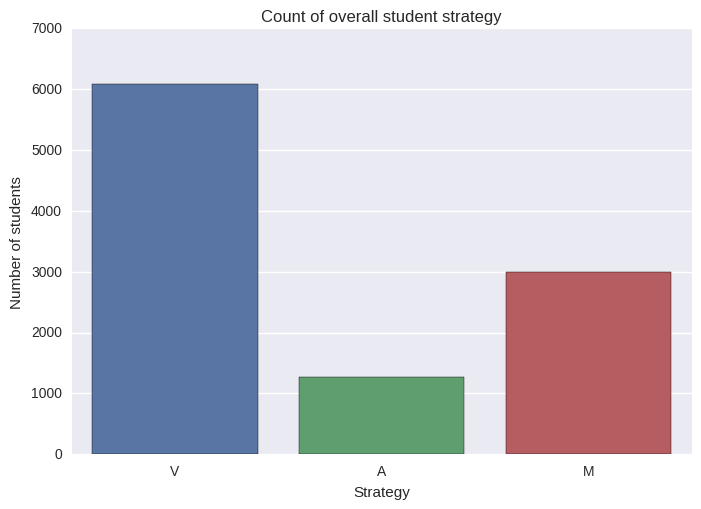

In [6]:
def getStrategy(pattern):
    return 'V' if pattern['numberOfVideosBeforeFirstProblem']>0 else 'A'

def getMergedStrategy(pattern):
    return ('M' if 'A' in pattern else 'V') if 'V' in pattern else 'A'

d = pd.DataFrame(rdd
 .map(lambda x: (x['StudentID'], getStrategy(x['Features'])))
 .groupByKey()
 .map(lambda x: { 'Strategy': getMergedStrategy(x[1]), 'StudentID': x[0], 'Count': len(x[1]) })
 .collect()
)

overall_strategies = d.set_index('StudentID').to_dict()['Strategy']
overall_counts = d.set_index('StudentID').to_dict()['Count']

sns.countplot(x='Strategy', data=d)

plt.title('Count of overall student strategy')
plt.ylabel('Number of students')
plt.xlabel('Strategy')
plt.show()

# Strategy per problem (A)-(V)

- V = start with video
- A = start with problem

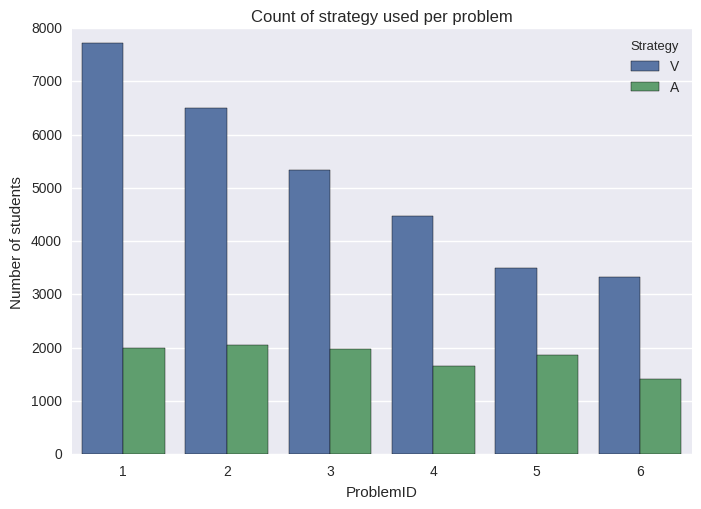

In [7]:
d = pd.DataFrame(rdd
 .map(lambda x: { 'ProblemID': utils.reOrderProblemID(x['ProblemID']), 'Strategy': getStrategy(x['Features']) })
 .collect()
)

sns.countplot(x='ProblemID', hue='Strategy', data=d)

plt.title('Count of strategy used per problem')
plt.ylabel('Number of students')
plt.xlabel('ProblemID')
plt.show()

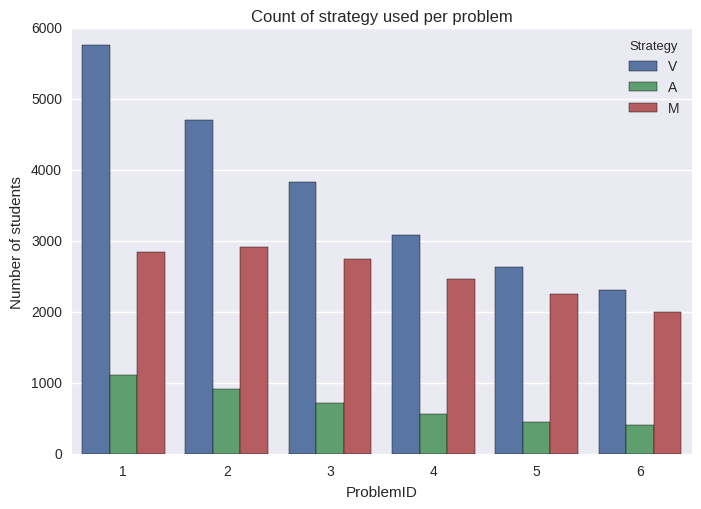

In [8]:
d = pd.DataFrame(rdd
 .map(lambda x: { 'ProblemID': utils.reOrderProblemID(x['ProblemID']), 'Strategy': overall_strategies[x['StudentID']] })
 .collect()
)

sns.countplot(x='ProblemID', hue='Strategy', data=d)

plt.title('Count of strategy used per problem')
plt.ylabel('Number of students')
plt.xlabel('ProblemID')
plt.show()

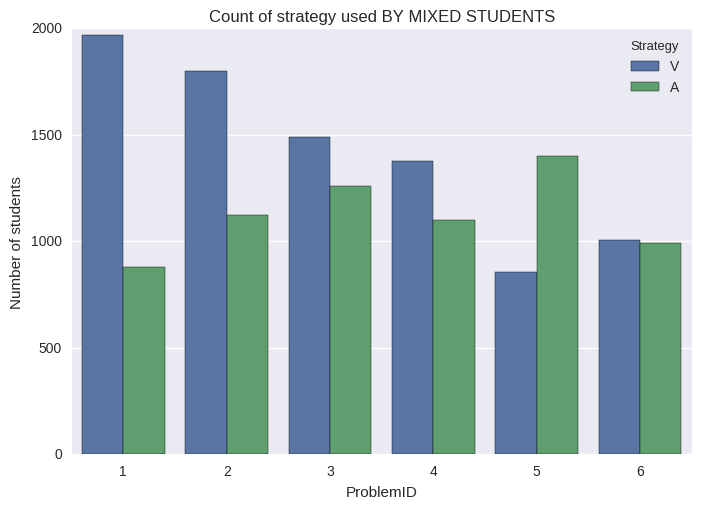

In [9]:
d = pd.DataFrame(rdd
 .map(lambda x: { 'ProblemID': utils.reOrderProblemID(x['ProblemID']), 'Strategy': getStrategy(x['Features']), 'Filter': overall_strategies[x['StudentID']] })
 .collect()
)

d = d[d.Filter == 'M']

sns.countplot(x='ProblemID', hue='Strategy', data=d)

plt.title('Count of strategy used BY MIXED STUDENTS')
plt.ylabel('Number of students')
plt.xlabel('ProblemID')
plt.show()

ProblemID
1    9.588633
2    9.309452
3    8.672344
4    8.772000
5    9.007146
6    8.503742
Name: Data, dtype: float64


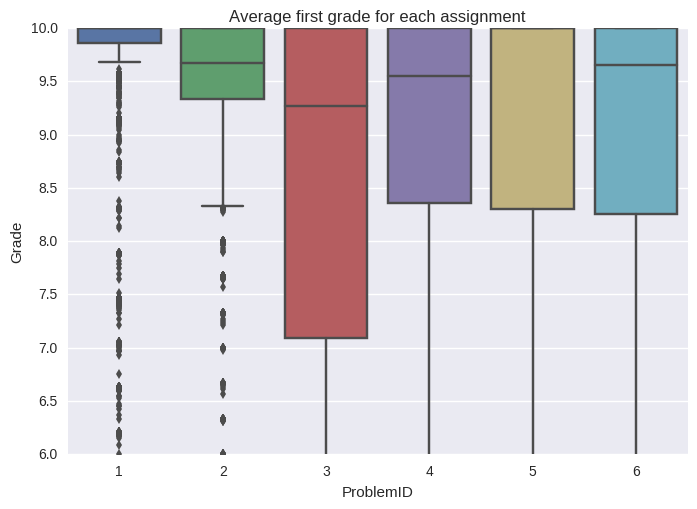

In [10]:
d = pd.DataFrame(rdd
 .map(lambda x: { 
    'ProblemID': utils.reOrderProblemID(x['ProblemID']), 
    'Data': x['Features']['firstProblemGrade'],
    'Filter': overall_counts[x['StudentID']]
 })
 .collect()
)

d = d[d.Filter == 6]

print(d.groupby('ProblemID')['Data'].mean())

g = sns.boxplot(x='ProblemID', y='Data', data=d)
g.set(ylim=[6, 10])

plt.title('Average first grade for each assignment')
plt.ylabel('Grade')
plt.xlabel('ProblemID')
plt.show()

In [11]:
def test(feature,yLim=None):
    d = pd.DataFrame(rdd
     .map(lambda x: (x['StudentID'], { 'Strategy': getStrategy(x['Features']), 'Data': x['Features'][feature] }))
     .groupByKey()
     .map(lambda x: { 'Strategy': getMergedStrategy([y['Strategy'] for y in list(x[1])]), 'Data': np.mean([y['Data'] for y in list(x[1])]) })
     .collect()
    )

    print('STATS', stats.f_oneway(
        d[d.Strategy=='V'].Data.tolist(),
        d[d.Strategy=='A'].Data.tolist(),
        d[d.Strategy=='M'].Data.tolist()
    ))

    print('\nMEANS'
        '\nV\t', d[d.Strategy=='V'].Data.mean(),
        '\nA\t', d[d.Strategy=='A'].Data.mean(),
        '\nM\t', d[d.Strategy=='M'].Data.mean(),
    )
    
    print('\nEFFECT SIZE'
        '\nV\t', (d[d.Strategy=='V'].Data.mean() - d[d.Strategy!='V'].Data.mean()) / d.Data.std(),
        '\nA\t', (d[d.Strategy=='A'].Data.mean() - d[d.Strategy!='A'].Data.mean()) / d.Data.std(),
        '\nM\t', (d[d.Strategy=='M'].Data.mean() - d[d.Strategy!='M'].Data.mean()) / d.Data.std(),
    )

    g = sns.boxplot(x='Strategy', y='Data', data=d)
    
    if not (yLim is None):
        g.set(ylim=yLim)
    
    plt.title('Comparison of ' + feature + ' for different strategy')
    plt.ylabel(feature)
    plt.xlabel('Strategy')
    plt.show()

# Average first and last grade per strategy

STATS F_onewayResult(statistic=5.0290597456015957, pvalue=0.0065609765537212742)

MEANS
V	 8.852899584968943 
A	 8.984029895316452 
M	 8.885108858639622

EFFECT SIZE
V	 -0.04575263663114124 
A	 0.08924423977906867 
M	 0.006999190241457143


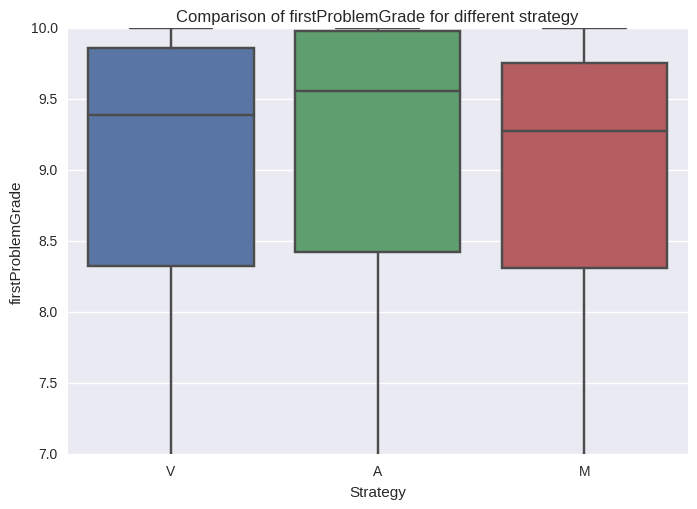

In [12]:
test('firstProblemGrade', yLim=[7,10])

STATS F_onewayResult(statistic=8.6372769872743227, pvalue=0.00017865187860301824)

MEANS
V	 9.482910815884622 
A	 9.517339859387532 
M	 9.56991769948712

EFFECT SIZE
V	 -0.0759035661722704 
A	 0.0060842651346170555 
M	 0.08627371268881065


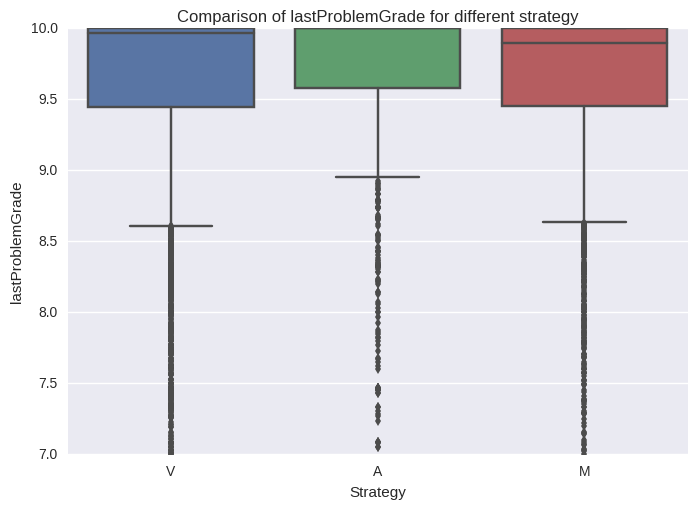

In [13]:
test('lastProblemGrade', yLim=[7,10])

# Average number of submission per strategy

STATS F_onewayResult(statistic=5.0799754323647965, pvalue=0.0062355917983699704)

MEANS
V	 1.7203176431863034 
A	 1.6637669801462913 
M	 1.7479117941864362

EFFECT SIZE
V	 -0.003089613662100015 
A	 -0.0830238642256985 
M	 0.04730368233284191


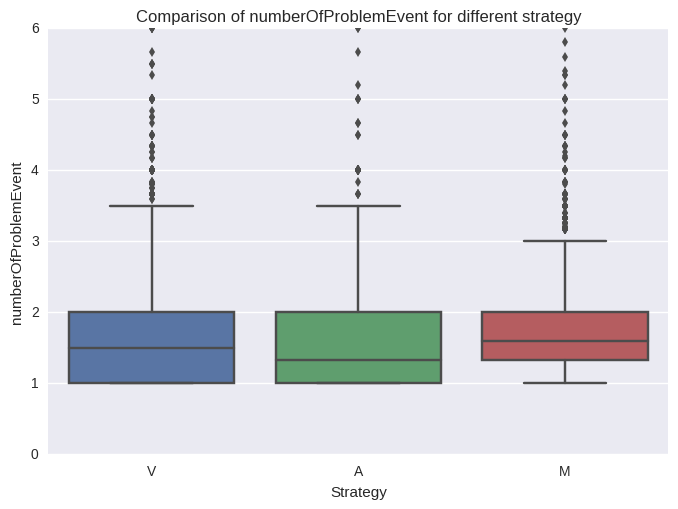

In [14]:
test('numberOfProblemEvent',yLim=[0, 6])

# Average resubmit time

STATS F_onewayResult(statistic=5.3556935807124404, pvalue=0.0047388570058617832)

MEANS
V	 0.1400939744640594 
A	 0.1527938865551224 
M	 0.1651953105804677

EFFECT SIZE
V	 -0.07185230395063578 
A	 0.011154729508865683 
M	 0.07504107369746511


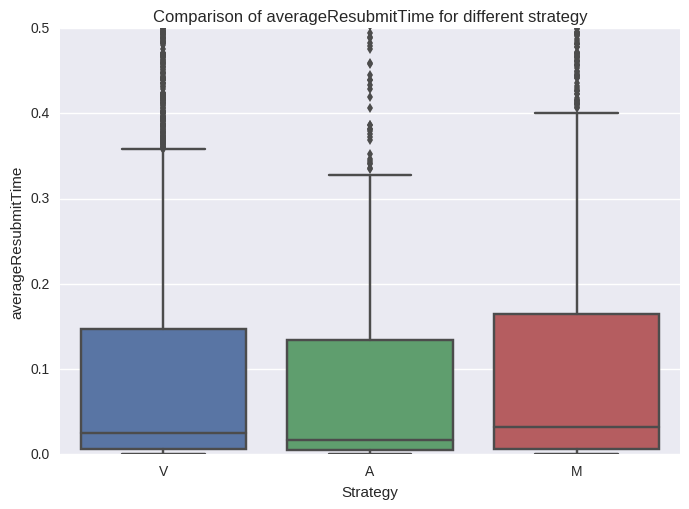

In [15]:
feature = 'averageResubmitTime'

d = pd.DataFrame(rdd
 .map(lambda x: (x['StudentID'], { 'Strategy': getStrategy(x['Features']), 'Data': x['Features'][feature] }))
 .groupByKey()
 .map(lambda x: { 'Strategy': getMergedStrategy([y['Strategy'] for y in list(x[1])]), 'Data': np.mean([y['Data'] for y in list(x[1])]) })
 .collect()
)

d = d[d.Data > 0]

print('STATS', stats.f_oneway(
    d[d.Strategy=='V'].Data.tolist(),
    d[d.Strategy=='A'].Data.tolist(),
    d[d.Strategy=='M'].Data.tolist()
))

print('\nMEANS'
    '\nV\t', d[d.Strategy=='V'].Data.mean(),
    '\nA\t', d[d.Strategy=='A'].Data.mean(),
    '\nM\t', d[d.Strategy=='M'].Data.mean(),
)

print('\nEFFECT SIZE'
    '\nV\t', (d[d.Strategy=='V'].Data.mean() - d[d.Strategy!='V'].Data.mean()) / d.Data.std(),
    '\nA\t', (d[d.Strategy=='A'].Data.mean() - d[d.Strategy!='A'].Data.mean()) / d.Data.std(),
    '\nM\t', (d[d.Strategy=='M'].Data.mean() - d[d.Strategy!='M'].Data.mean()) / d.Data.std(),
)

g = sns.boxplot(x='Strategy', y='Data', data=d)

yLim = [0, 0.5]
if not (yLim is None):
    g.set(ylim=yLim)

plt.title('Comparison of ' + feature + ' for different strategy')
plt.ylabel(feature)
plt.xlabel('Strategy')
plt.show()

# Number of Homework done per strategy

F_onewayResult(statistic=712.05498837302378, pvalue=1.893646960515786e-290)

V	 3.6772547728768927 
A	 3.2876175548589344 
M	 5.096224523889075

EFFECT SIZE
V	 -0.445785206243376 
A	 -0.4354088580575353 
M	 0.7544601291117347


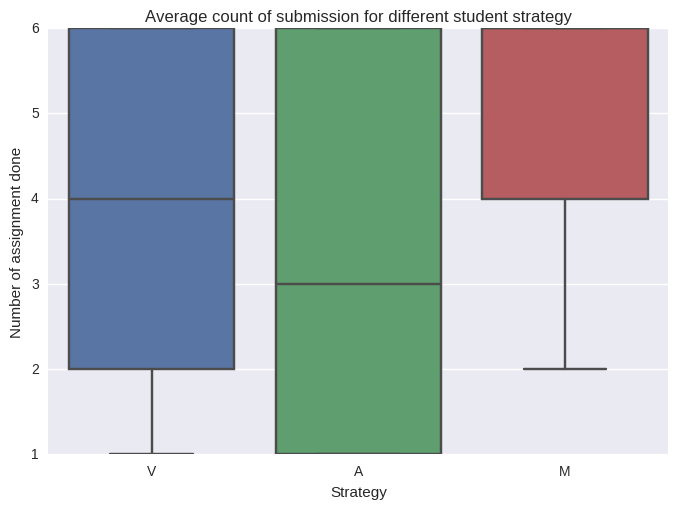

In [16]:
d = pd.DataFrame(rdd
 .map(lambda x: (x['StudentID'], { 'Strategy': getStrategy(x['Features']) }))
 .groupByKey()
 .map(lambda x: { 'Strategy': getMergedStrategy([y['Strategy'] for y in list(x[1])]), 'Data': len(x[1]) })
 .collect()
)

print(stats.f_oneway(
    d[d.Strategy=='V'].Data.tolist(),
    d[d.Strategy=='A'].Data.tolist(),
    d[d.Strategy=='M'].Data.tolist()
))

print(
    '\nV\t', d[d.Strategy=='V'].Data.mean(),
    '\nA\t', d[d.Strategy=='A'].Data.mean(),
    '\nM\t', d[d.Strategy=='M'].Data.mean(),
)
    
print('\nEFFECT SIZE'
    '\nV\t', (d[d.Strategy=='V'].Data.mean() - d[d.Strategy!='V'].Data.mean()) / d.Data.std(),
    '\nA\t', (d[d.Strategy=='A'].Data.mean() - d[d.Strategy!='A'].Data.mean()) / d.Data.std(),
    '\nM\t', (d[d.Strategy=='M'].Data.mean() - d[d.Strategy!='M'].Data.mean()) / d.Data.std(),
)

g = sns.boxplot('Strategy', 'Data', data=d)

plt.title('Average count of submission for different student strategy')
plt.ylabel('Number of assignment done')
plt.xlabel('Strategy')
plt.show()

# Grade comparison (A)-(V)-(M)

 F_onewayResult(statistic=622.92307477154657, pvalue=3.6473271934153971e-256)

V	 56.44359950082278 
A	 50.388105493730464 
M	 78.82628104577354

EFFECT SIZE
V	 -0.4214447204246688 
A	 -0.4080814268455903 
M	 0.7113968004992657


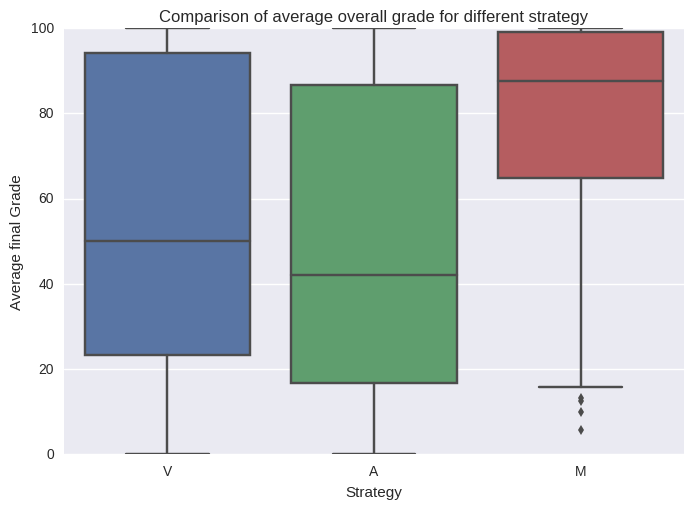

In [17]:
g = df_grades.to_dict()['Grade']

d = pd.DataFrame(rdd
 .map(lambda x: (x['StudentID'], { 'Strategy': getStrategy(x['Features']), 'Data': 0 }))
 .groupByKey()
 .map(lambda x: { 'Strategy': getMergedStrategy([y['Strategy'] for y in list(x[1])]), 'Data': g.get(x[0],-1) })
 .collect()
)

print('', stats.f_oneway(
    d[d.Strategy=='V'].Data.tolist(),
    d[d.Strategy=='A'].Data.tolist(),
    d[d.Strategy=='M'].Data.tolist()
))

print(
    '\nV\t', d[d.Strategy=='V'].Data.mean(),
    '\nA\t', d[d.Strategy=='A'].Data.mean(),
    '\nM\t', d[d.Strategy=='M'].Data.mean(),
)
    
print('\nEFFECT SIZE'
    '\nV\t', (d[d.Strategy=='V'].Data.mean() - d[d.Strategy!='V'].Data.mean()) / d.Data.std(),
    '\nA\t', (d[d.Strategy=='A'].Data.mean() - d[d.Strategy!='A'].Data.mean()) / d.Data.std(),
    '\nM\t', (d[d.Strategy=='M'].Data.mean() - d[d.Strategy!='M'].Data.mean()) / d.Data.std(),
)

sns.boxplot(x='Strategy', y='Data', data=d)

plt.title('Comparison of average overall grade for different strategy')
plt.ylabel('Average final Grade')
plt.xlabel('Strategy')
plt.show()

# Average time by strategy

STATS F_onewayResult(statistic=3007.2617423056317, pvalue=0.0)

MEANS
V	 4.32144659343911 
A	 0.15506490325307648 
M	 2.263838672824039

EFFECT SIZE
V	 1.1152770089458643 
A	 -1.4469660315908475 
M	 -0.5537129097816559


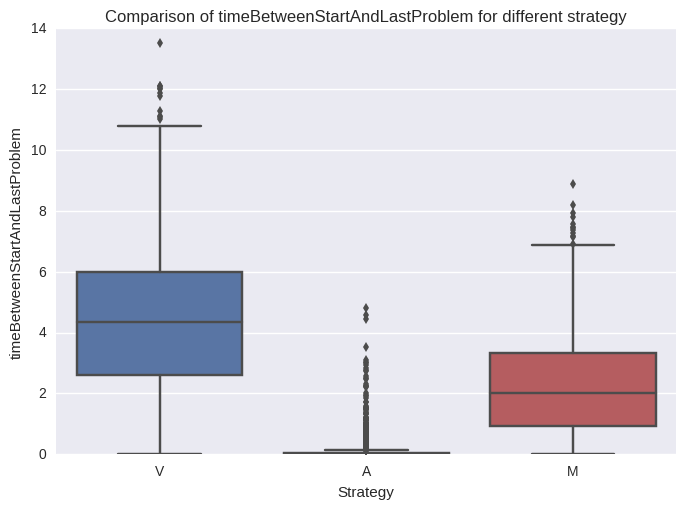

In [18]:
test('timeBetweenStartAndLastProblem')

STATS F_onewayResult(statistic=24.602477799733641, pvalue=2.1908724153251179e-11)

MEANS
V	 0.1672224237589298 
A	 0.15506490325307648 
M	 0.22943957705582574

EFFECT SIZE
V	 -0.09350469719729702 
A	 -0.07644403039623576 
M	 0.15042262355686828


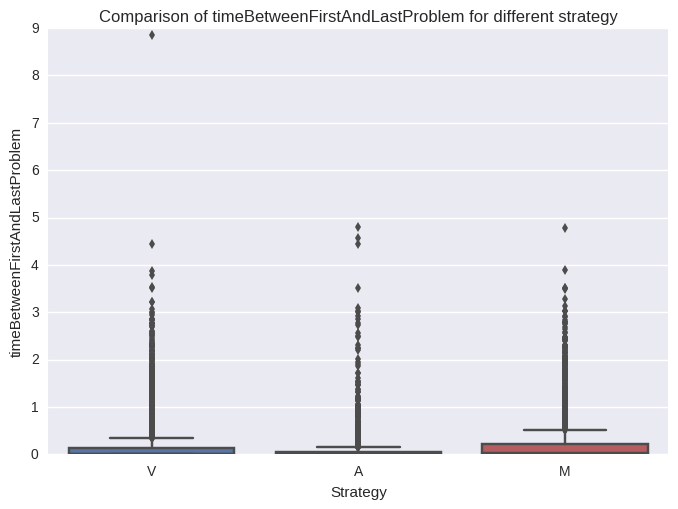

In [19]:
test('timeBetweenFirstAndLastProblem')